# Demo of `calcualte_cooks_d_like_influence` function

This notebook provides a simple code demo of the `calculate_cooks_d_like_influence` function. For a deeper dive into its design, theory, and practical usage, pls see this article published on TDS as an Editor's Pick: [**Help Your Model Learn the True Signal: An Algorithm-Agnostic Approach Inspired by Cook's Distance**](https://towardsdatascience.com/help-your-model-learn-the-true-signal/)

## Overview

Some data points disproportionately disrupt a model's ability to learn the dominant signal. This notebook demonstrates an **algorithm-agnostic approach** inspired by Cook's Distance to identify and manage these disruptive observations, helping models capture stable, generalizable patterns.

**Key Function:**
- `calculate_cooks_d_like_influence()`: Identifies influential points across any sklearn-compatible ML regressors

**Why This Matters:**
- **Standard outlier detection** finds "weird" data points
- **Cook's-D like influence** finds data points that make your *model itself* "weird" in its behavior
- Works with any sklearn-compatible model: Linear Regression, Random Forest, LightGBM, XGBoost, etc.

In [1]:
# Standard library imports
import warnings
import time
from typing import Dict, Any
import os
import multiprocessing

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns

# MLArena imports
from mlarena import MLPipeline, PreProcessor
from mlarena.utils.stats_utils import calculate_cooks_d_like_influence

# Configure plotting
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
MPL_BLUE = colors[0]  # Main distribution/points color
MPL_RED = colors[3]  # Highlight influential points
MPL_YELLOW = colors[1]  # Highlight influential points
MPL_GREEN = colors[2]  # Highlight influential points

# Configure parallel processing
# Only needed when running locally (not required on distributed platforms like Databricks)
n_cores = multiprocessing.cpu_count()
n_jobs = max(1, n_cores // 2)  # Use half of available cores to avoid overloading
os.environ["LOKY_MAX_CPU_COUNT"] = str(n_jobs)

In [2]:
def custom_warning_format(message, category, filename, lineno, file=None, line=None):
    return f'{category}: {message}\n'
warnings.formatwarning = custom_warning_format

## 1. Create Synthetic Dataset with Planted Disruptive Points

We'll create a synthetic dataset where houe prices is a function of age, size and number of bedrooms. But also let's intentionally plant some **disruptors** with "currency mix-up" errors to simulate real-world data quality issues where some prices were recorded in different currencies.

In [3]:
# create a synthetic dataset
n_samples = 1000
random_state = 42
np.random.seed(random_state)

# Create three meaningful independent variables
X = pd.DataFrame({
    "sqft": np.random.normal(2000, 500, n_samples),         # Square footage
    "bedrooms": np.random.randint(2, 6, n_samples),         # Number of bedrooms
    "age": np.random.normal(20, 10, n_samples)              # Age of the house
})
noise_std = 0.05 * 300_000 
noise = np.random.normal(0, noise_std, n_samples)
y = 150 * X["sqft"] + 20000 * X["bedrooms"] - 1000 * X["age"] + noise
y = pd.Series(y, name="price")

print(f"Original dataset shape: {X.shape}")
print(f"Target variable range: ${y.min():.1f}K - ${y.max():.1f}K")
print(f"Target variable mean: ${y.mean():.1f}K")


Original dataset shape: (1000, 3)
Target variable range: $78841.3K - $619101.8K
Target variable mean: $350667.7K


In [4]:
# Split data for training and evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 800 samples
Test set: 200 samples


Now let's plant disruptive points in the training set.


Planted 50 disruptive points at indices: [np.int32(23), np.int32(30), np.int32(39), np.int32(63), np.int32(65), np.int32(66), np.int32(67), np.int32(78), np.int32(139), np.int32(174), np.int32(215), np.int32(244), np.int32(250), np.int32(260), np.int32(286), np.int32(323), np.int32(327), np.int32(346), np.int32(360), np.int32(377), np.int32(383), np.int32(395), np.int32(398), np.int32(423), np.int32(456), np.int32(490), np.int32(525), np.int32(526), np.int32(529), np.int32(533), np.int32(534), np.int32(570), np.int32(578), np.int32(595), np.int32(596), np.int32(604), np.int32(610), np.int32(621), np.int32(622), np.int32(635), np.int32(637), np.int32(658), np.int32(667), np.int32(692), np.int32(696), np.int32(721), np.int32(741), np.int32(746), np.int32(760), np.int32(796)]
New target range: $78841.3K - $717126.0K
New target mean: $350459.2K


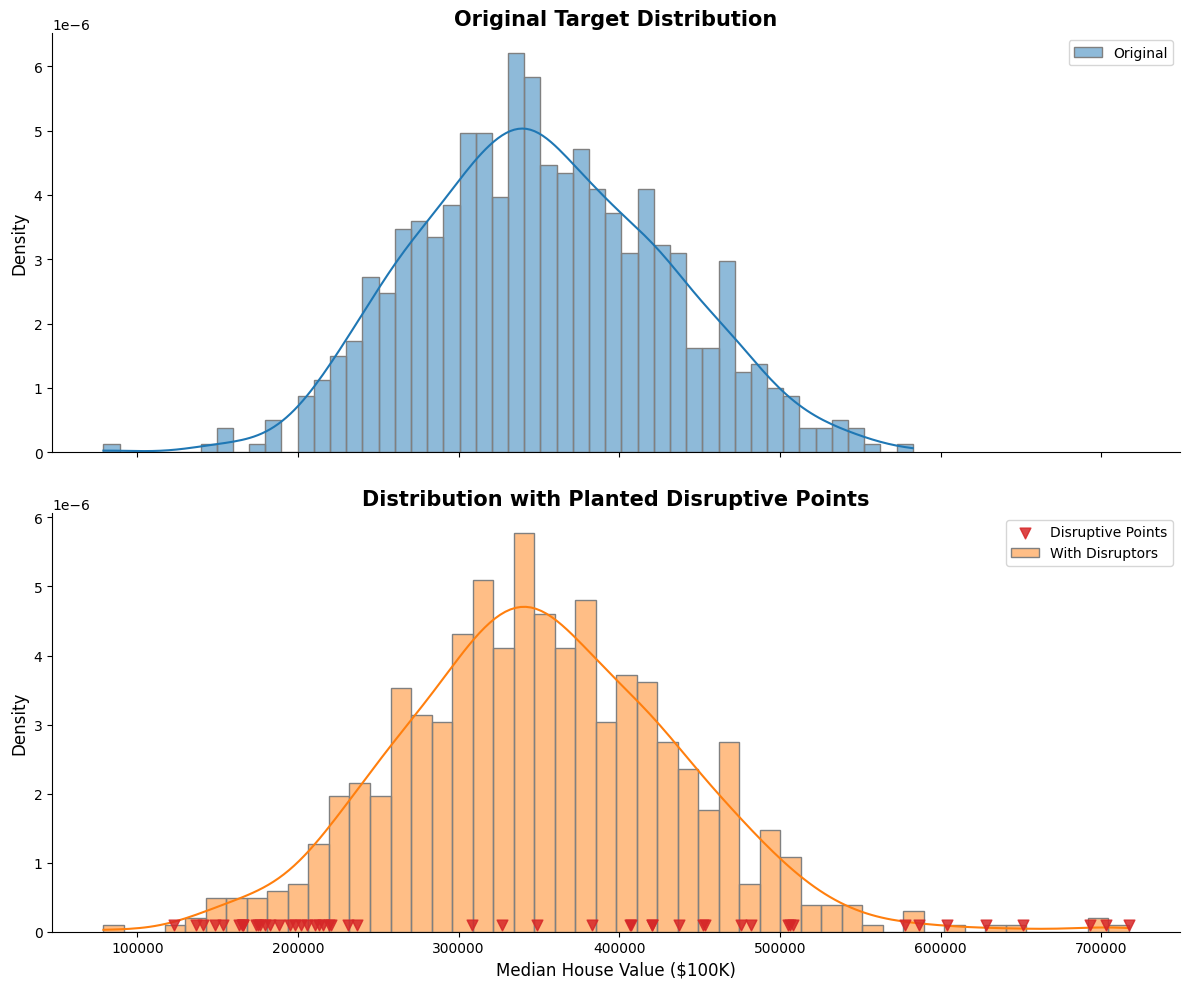

In [5]:
# Plant disruptive points: simulate currency mix-up errors
# Some house prices were accidentally recorded in a different currencies
# This makes them appear much cheaper/expensive than they actually are

np.random.seed(42)
n_disruptive = 50 if len(X_train)//100 < 10 else int(len(X_train))//100

# Create a copy for manipulation
X_with_disruptors = X_train.copy()
y_with_disruptors = y_train.copy()

# Randomly select indices for disruptive points
disruptive_indices = np.random.choice(len(X_train), size=n_disruptive, replace=False)

# Plant different types of currency errors
for i, idx in enumerate(disruptive_indices):
    if i <= n_disruptive//2:  # Currency conversion error: prices too low 
        y_with_disruptors.iloc[idx] = y_with_disruptors.iloc[idx] * 0.5  # Much lower
    else:  # Currency conversion error: prices too high (different scale)
        y_with_disruptors.iloc[idx] = y_with_disruptors.iloc[idx] * 1.5  # Much higher

print(f"\nPlanted {n_disruptive} disruptive points at indices: {sorted(disruptive_indices)}")
print(f"New target range: ${y_with_disruptors.min():.1f}K - ${y_with_disruptors.max():.1f}K")
print(f"New target mean: ${y_with_disruptors.mean():.1f}K")

# Visualize with vertically stacked plots for easier comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot original target distribution
sns.histplot(y_train, bins=50, kde=True, ax=ax1, color=MPL_BLUE, label='Original', stat="density", edgecolor='grey')
ax1.set_title('Original Target Distribution', fontsize=15, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12)
ax1.set_xlabel('')
ax1.legend()
sns.despine(ax=ax1)

# Plot distribution with disruptors
sns.histplot(y_with_disruptors, bins=50, kde=True, ax=ax2, color=MPL_YELLOW, label='With Disruptors', stat="density", edgecolor='grey')
# Overlay disruptive points
ax2.scatter(
    y_with_disruptors.iloc[disruptive_indices], 
    [0.0000001]*len(disruptive_indices), 
    color=MPL_RED, s=60, alpha=0.85, label='Disruptive Points', zorder=5, marker='v'
)
ax2.set_title('Distribution with Planted Disruptive Points', fontsize=15, fontweight='bold')
ax2.set_xlabel('Median House Value ($100K)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.legend()
sns.despine(ax=ax2)

plt.tight_layout(h_pad=2)
plt.show()

## 2. Baseline Model Performance (With Disruptive Points)

Let's train models on the training set containing disruptive points and see how they perform.

Training baseline model with disruptive points...

=== Regression Metrics & Diagnostics ===

1. Error Metrics
----------------------------------------
• RMSE:         27352.049      (Root Mean Squared Error)
• MAE:          21334.239      (Mean Absolute Error)
• Median AE:    16297.573      (Median Absolute Error)
• NRMSE Mean:   7.9%      (RMSE/mean)
• NRMSE Std:    34.9%      (RMSE/std)
• NRMSE IQR:    25.9%      (RMSE/IQR)
• MAPE:         6.3%      (Mean Abs % Error, excl. zeros)
• SMAPE:        6.3%      (Symmetric Mean Abs % Error)

2. Goodness of Fit
----------------------------------------
• R²:           0.878      (Coefficient of Determination)
• Adj. R²:      0.877      (Adjusted for # of features)

3. Improvement over Baseline
----------------------------------------
• vs Mean:      65.1%      (RMSE improvement)
• vs Median:    65.1%      (RMSE improvement)


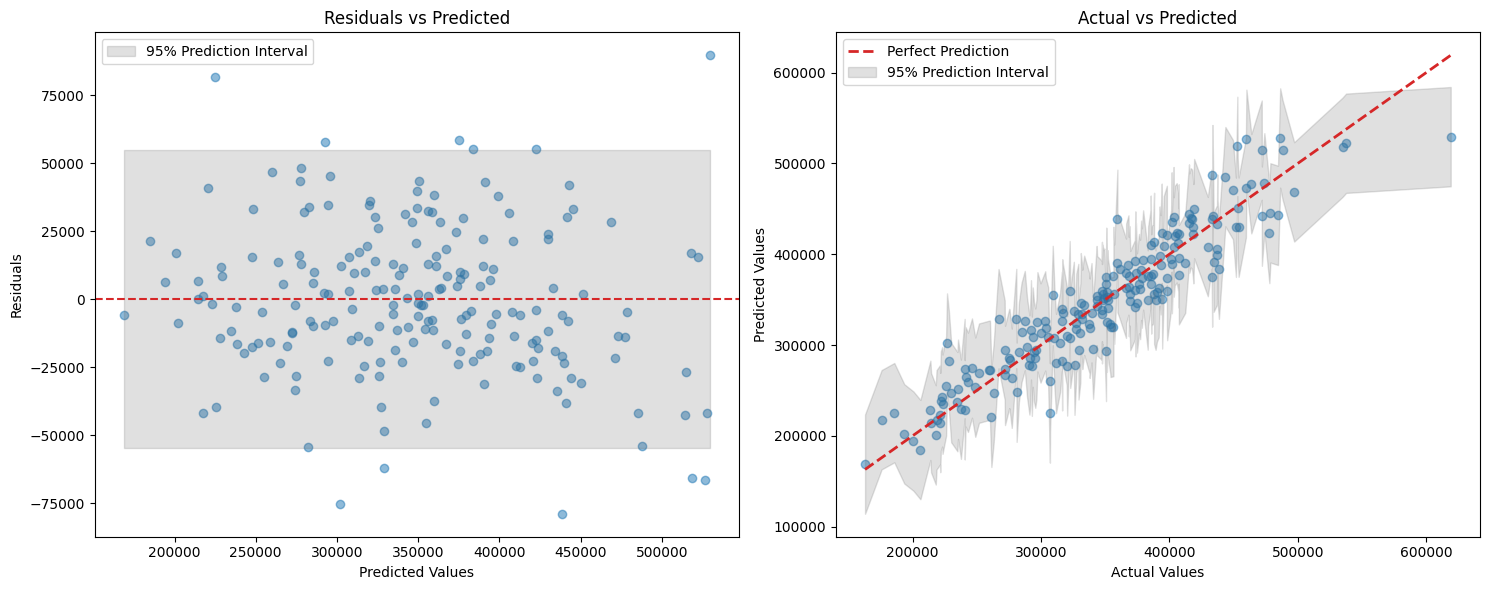

In [6]:
# Train baseline model using MLPipeline
baseline_pipeline = MLPipeline(
    model=lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    preprocessor=PreProcessor()
)

print("Training baseline model with disruptive points...")
baseline_pipeline.fit(X_with_disruptors, y_with_disruptors)

# Evaluate baseline performance
baseline_results = baseline_pipeline.evaluate(
    X_test, y_test, 
    verbose=True, 
    visualize=True
)

## 3. Cook's-like Influence Analysis

Now let's identify which data points are most disruptive to the model's learning using our Cook's-like influence measure.

### 3.1 Run the influence across all observations

Calculating Cook's-like influence scores...
This may take a few minutes as we retrain the model multiple times...
Performing Cook's-D-like influence calculation for ALL points.
  Processed 81/800 selected samples.
  Processed 162/800 selected samples.
  Processed 243/800 selected samples.
  Processed 324/800 selected samples.
  Processed 405/800 selected samples.
  Processed 486/800 selected samples.
  Processed 567/800 selected samples.
  Processed 648/800 selected samples.
  Processed 729/800 selected samples.
  Processed 800/800 selected samples.
Selected top 50 most influential points.


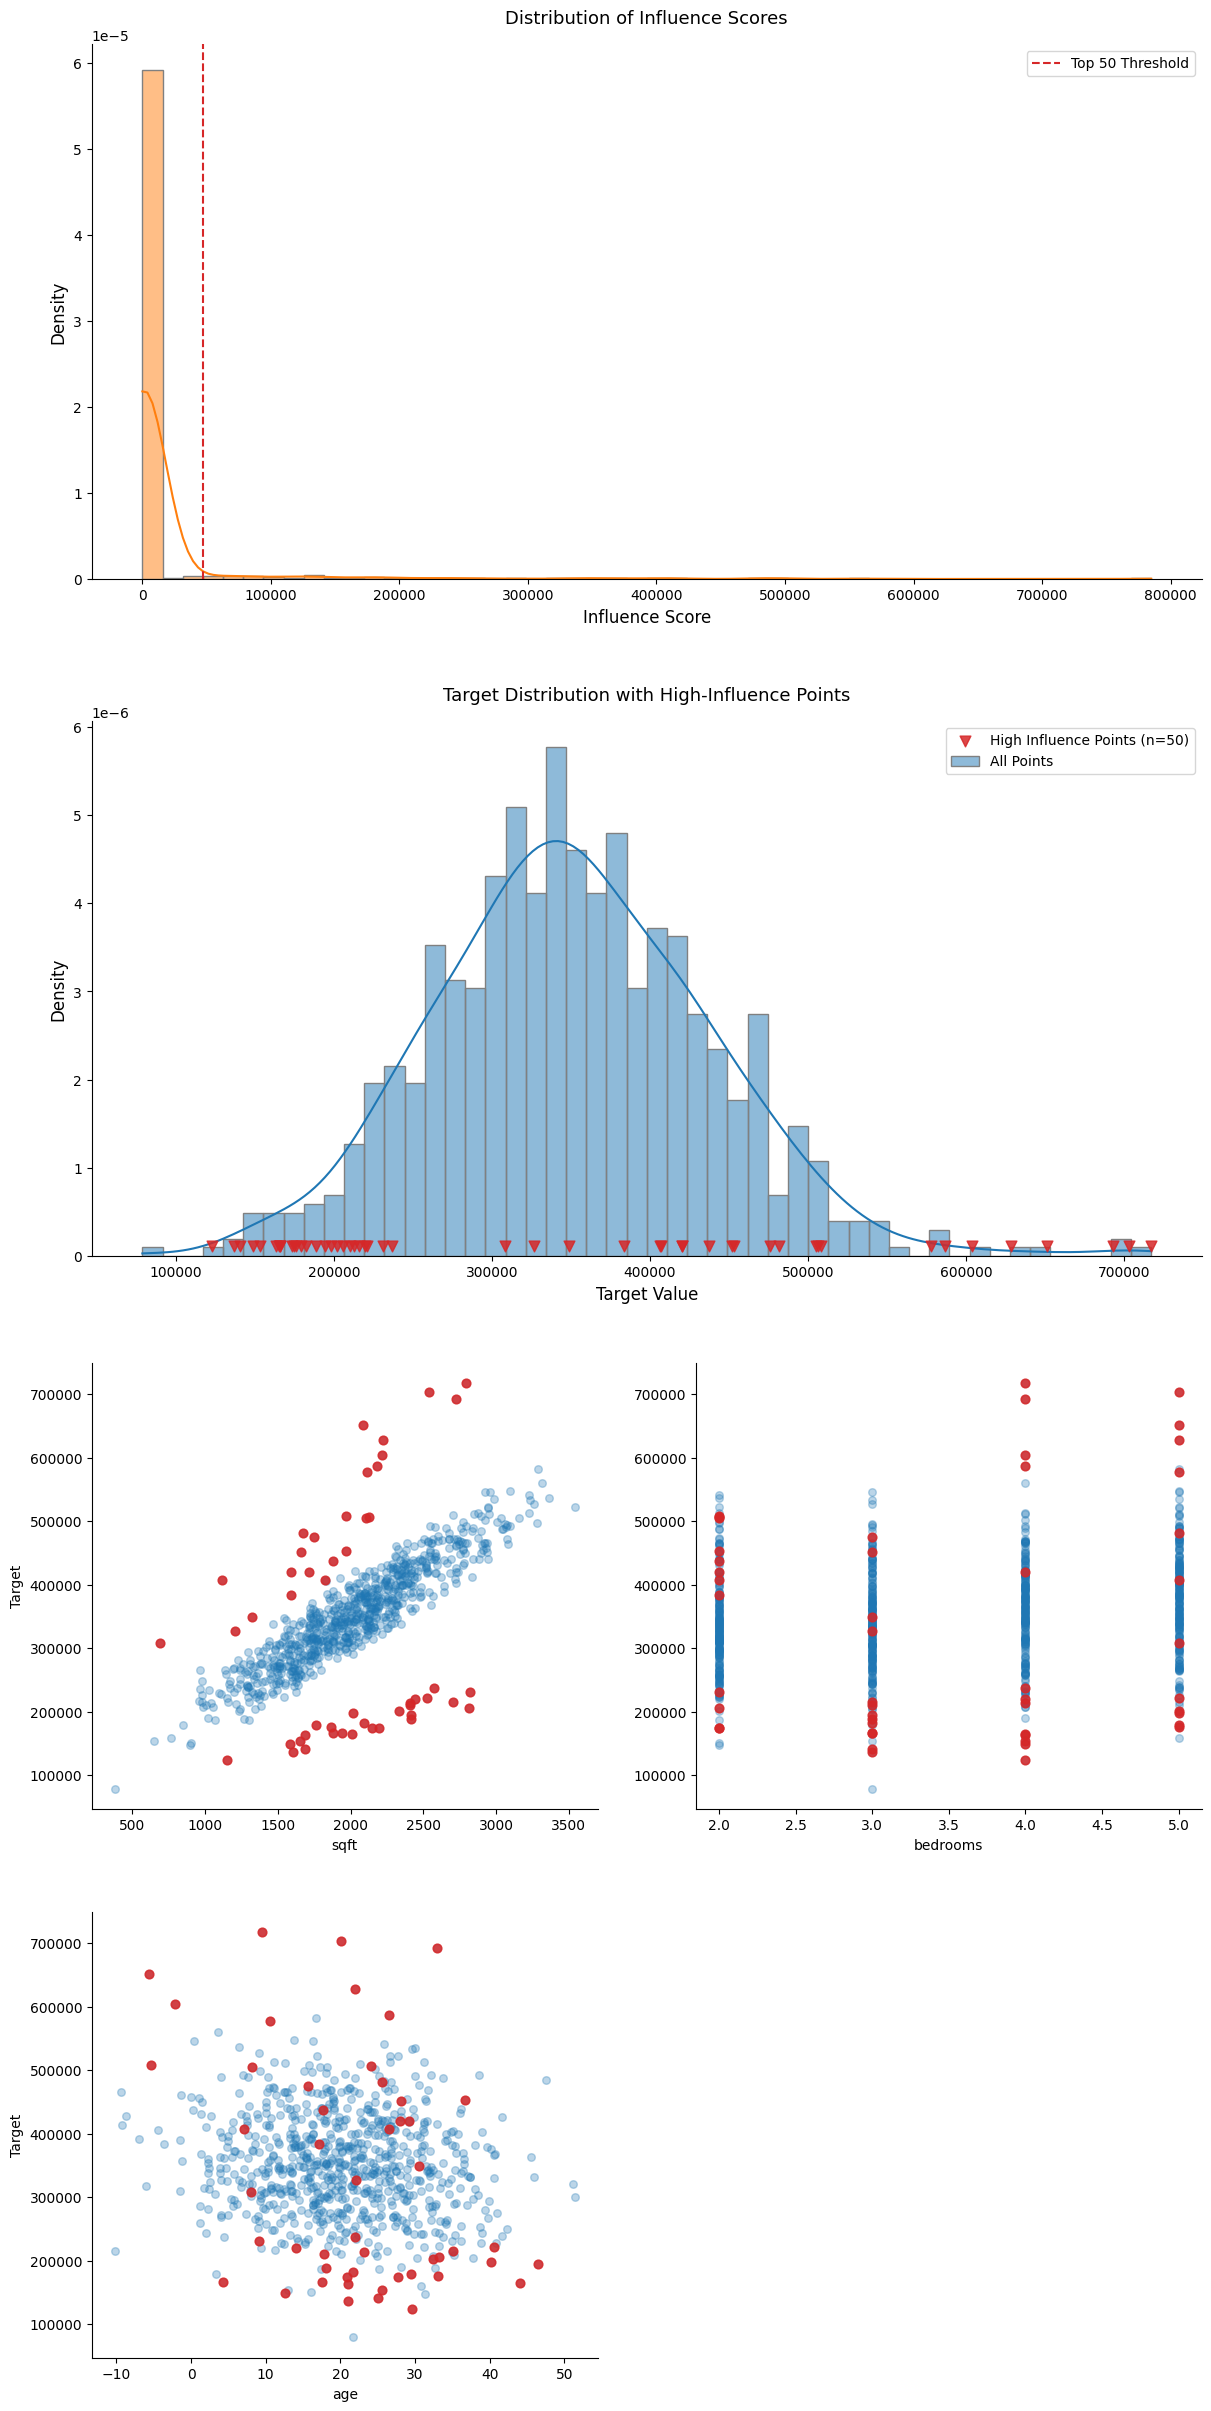


Influence calculation completed in 2.0 seconds
Influence scores shape: (800,)
Max influence score: 784926.482
Min influence score: 0.000


In [7]:
# Calculate Cook's-like influence scores
print("Calculating Cook's-like influence scores...")
print("This may take a few minutes as we retrain the model multiple times...")

start_time = time.time()
influence_scores, influential_indices, normal_indices = calculate_cooks_d_like_influence(
    model_class = LinearRegression,
    X = X_with_disruptors,
    y = y_with_disruptors,
    visualize = True,
    influence_outlier_method = "top_k",
    influence_outlier_threshold = 50,  
    random_state = 42
)


elapsed_time = time.time() - start_time
print(f"\nInfluence calculation completed in {elapsed_time:.1f} seconds")
print(f"Influence scores shape: {influence_scores.shape}")
print(f"Max influence score: {influence_scores.max():.3f}")
print(f"Min influence score: {influence_scores.min():.3f}")

In [8]:
# Analyze the most influential points
# Get indices of top influential points
n_top = 50
top_influential_idx = np.argsort(influence_scores)[-n_top:][::-1]
top_scores = influence_scores[top_influential_idx]

print(f"Top {n_top} most influential points:")
print("Index | Influence Score | Actual Value | Planted Disruptive?")
print("-" * 60)

for i, (idx, score) in enumerate(zip(top_influential_idx, top_scores)):
    # print(idx)
    # actual_idx = X_with_disruptors.index[idx]  # Convert back to original index
    # print(actual_idx)
    actual_value = y_with_disruptors.iloc[idx]
    is_disruptive = "YES" if idx in disruptive_indices else "No"
    print(f"{idx:5d} | {score:13.6f} | ${actual_value:10.1f}K | {is_disruptive}")

# Calculate detection accuracy
detected_disruptors = sum(1 for idx in top_influential_idx 
                         if idx in disruptive_indices)
print(f"\nDetection Results:")
print(f"Top {n_top} influential points contain {detected_disruptors} planted disruptors")
print(f"Detection rate: {detected_disruptors/min(len(disruptive_indices), n_top)*100:.1f}%")

Top 50 most influential points:
Index | Influence Score | Actual Value | Planted Disruptive?
------------------------------------------------------------
  692 | 784926.482111 | $  651253.3K | YES
  327 | 558449.448668 | $  220814.7K | YES
   63 | 495352.662407 | $  205812.9K | YES
  796 | 486458.163743 | $  693110.5K | YES
  760 | 483468.106885 | $  231152.3K | YES
  174 | 417650.489443 | $  717126.0K | YES
  570 | 402389.561006 | $  703087.5K | YES
  610 | 397853.288733 | $  194687.1K | YES
  139 | 368766.611539 | $  507905.2K | YES
  526 | 352996.402308 | $  215681.7K | YES
  383 | 343986.726536 | $  603955.5K | YES
   65 | 329236.504639 | $  201731.9K | YES
  696 | 288166.958106 | $  165001.5K | YES
   66 | 258160.822227 | $  198052.8K | YES
  637 | 236665.786348 | $  453290.2K | YES
  578 | 235810.030763 | $  628506.7K | YES
   23 | 225677.720846 | $  406628.9K | YES
  323 | 204182.739981 | $  420210.0K | YES
  377 | 190545.797617 | $  176228.4K | YES
  346 | 187530.144334 | $  16

### 3.2 Focus on max_loo_points to save on compute

Selecting 100 points with highest absolute residuals for LOO calculation...
  Processed 11/100 selected samples.
  Processed 22/100 selected samples.
  Processed 33/100 selected samples.
  Processed 44/100 selected samples.
  Processed 55/100 selected samples.
  Processed 66/100 selected samples.
  Processed 77/100 selected samples.
  Processed 88/100 selected samples.
  Processed 99/100 selected samples.
  Processed 100/100 selected samples.
Identified 40 influential points


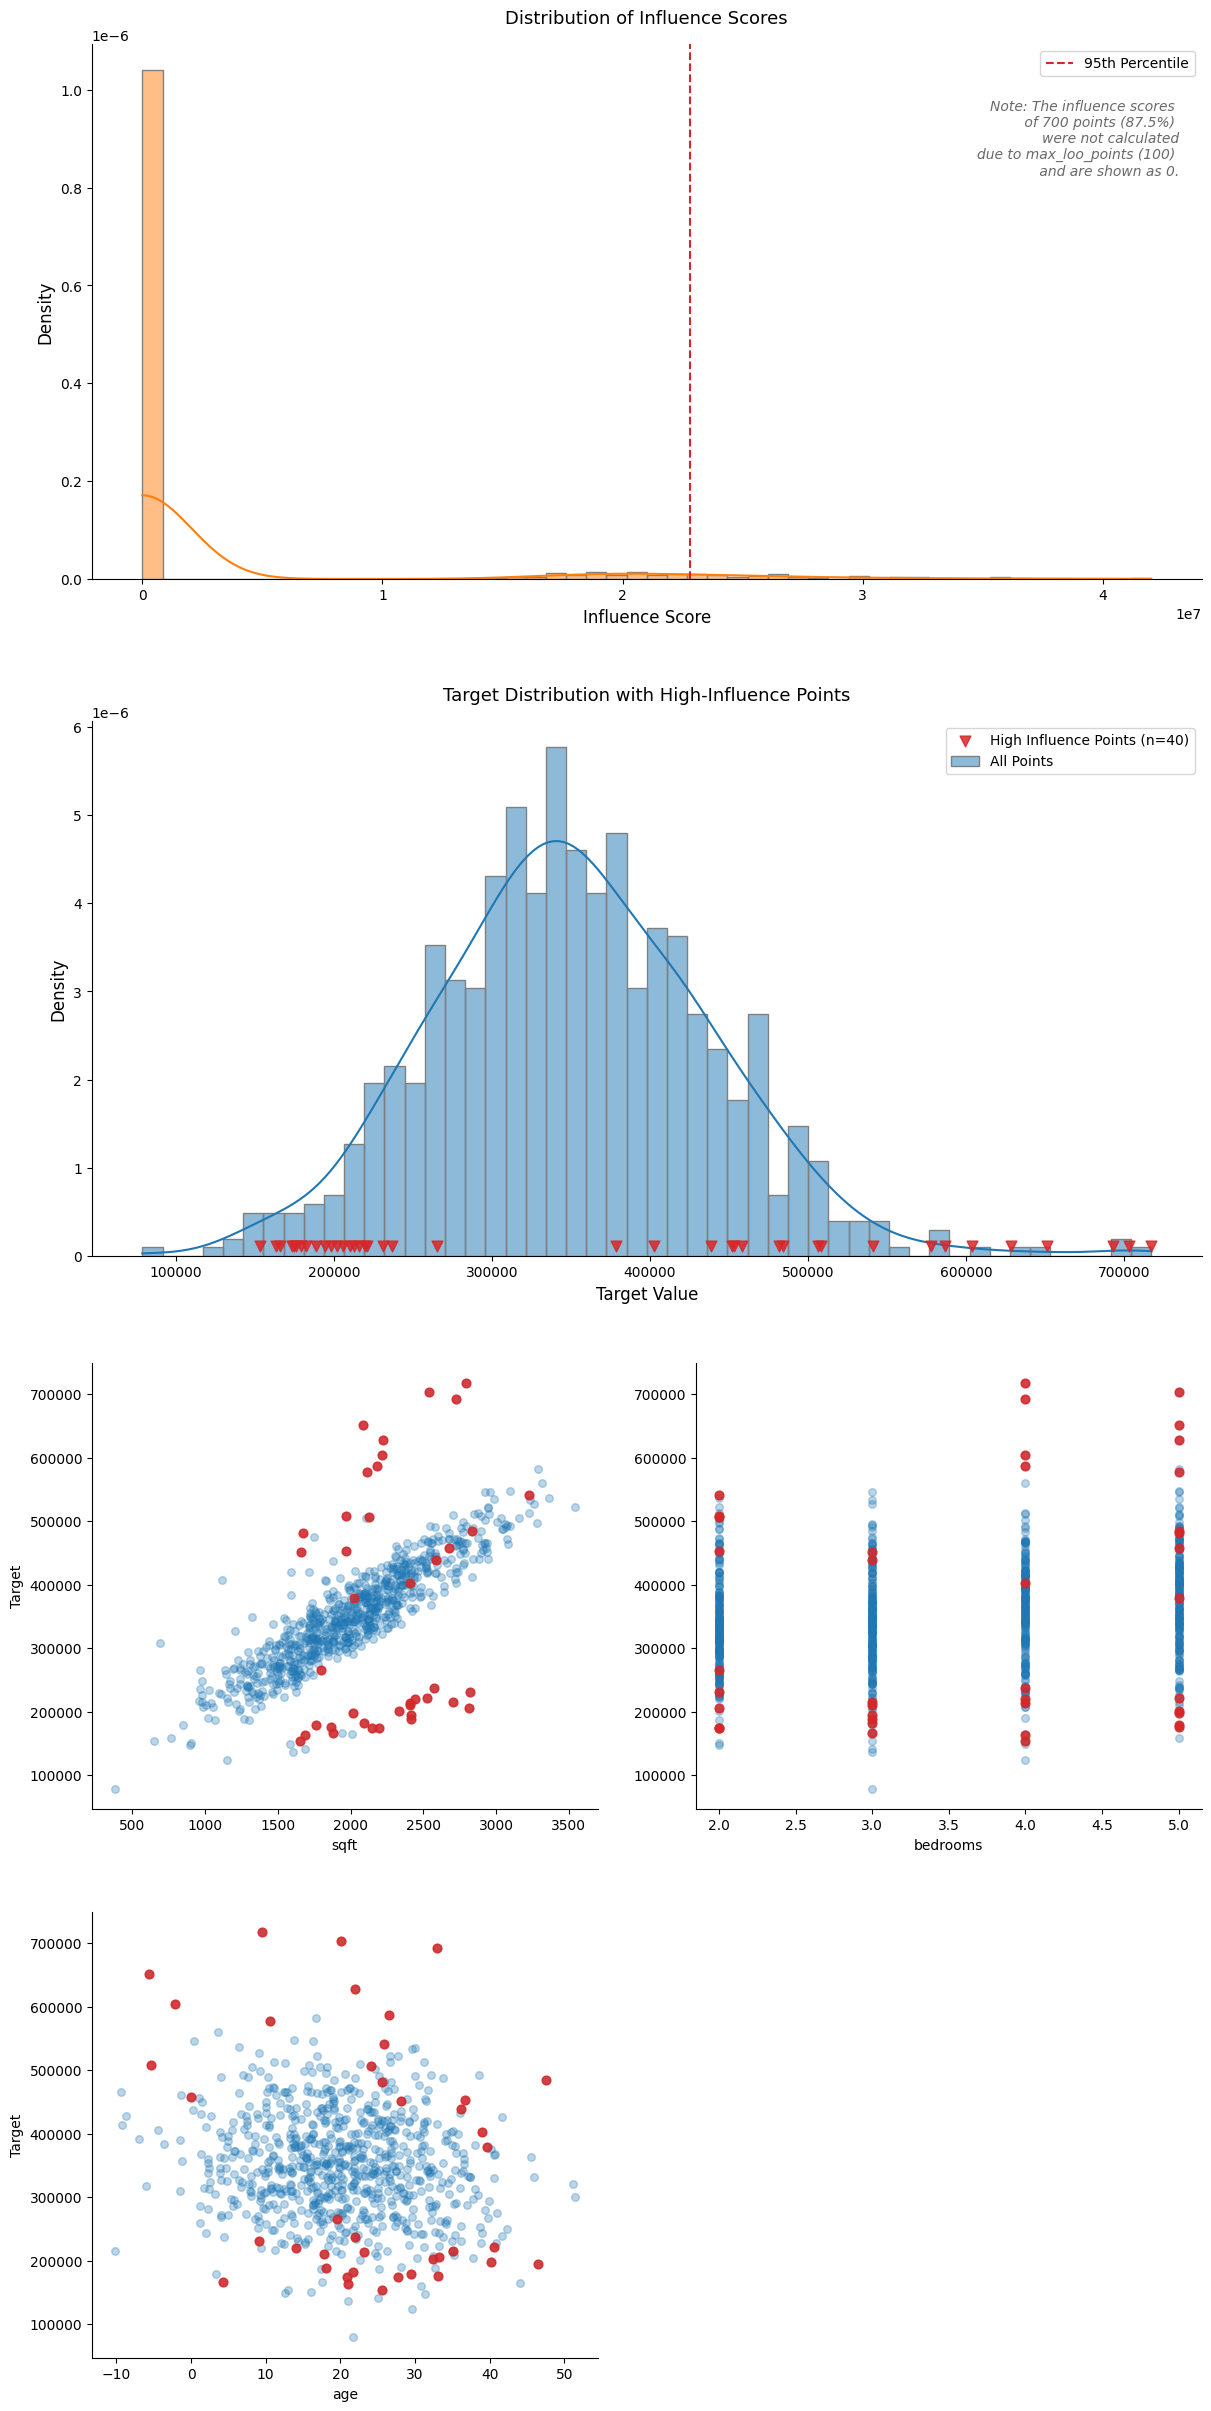


Influence calculation completed in 2.9 seconds
  796 | 42013324.953010 | $  693110.5K | YES
   63 | 36541204.623497 | $  205812.9K | YES
  327 | 36074724.714902 | $  220814.7K | YES
  760 | 35914388.793711 | $  231152.3K | YES
  174 | 32725517.767684 | $  717126.0K | YES
  456 | 32655053.909597 | $  236821.7K | YES
  570 | 31448090.996252 | $  703087.5K | YES
  526 | 31224281.745561 | $  215681.7K | YES
  667 | 31127169.614559 | $  213057.4K | YES
  658 | 29941148.591662 | $  219456.5K | YES
  692 | 29615466.471377 | $  651253.3K | YES
  578 | 29556936.310112 | $  628506.7K | YES
  746 | 29508034.966544 | $  481921.4K | YES
  492 | 27854501.437577 | $  458462.8K | No
  622 | 27351903.344674 | $  188422.7K | YES
  250 | 27315365.372078 | $  506314.8K | YES
  377 | 27305349.410566 | $  176228.4K | YES
  360 | 26832237.009393 | $  173542.2K | YES
   30 | 26784593.779454 | $  179240.7K | YES
   65 | 26541096.482837 | $  201731.9K | YES
  610 | 26444235.119301 | $  194687.1K | YES
   39 | 

In [9]:

start_time = time.time()

model_params={'verbose': -1, 'n_estimators': 50}

influence_scores, influential_indices, normal_indices = calculate_cooks_d_like_influence(
    model_class = lgb.LGBMRegressor,
    X = X_with_disruptors,
    y = y_with_disruptors,
    visualize = True,
    max_loo_points = 100,  # Focus on top n high-residual points
    influence_outlier_method = "percentile",
    influence_outlier_threshold = 95,  
    random_state = 42,
    **model_params
)

elapsed_time = time.time() - start_time
print(f"\nInfluence calculation completed in {elapsed_time:.1f} seconds")
# print(f"Influence scores shape: {influence_scores.shape}")
# print(f"Max influence score: {influence_scores.max():.3f}")
# print(f"Min influence score: {influence_scores.min():.3f}")

top_influential_idx = np.argsort(influence_scores)[-n_top:][::-1]
top_scores = influence_scores[top_influential_idx]

for i, (idx, score) in enumerate(zip(top_influential_idx, top_scores)):
    actual_value = y_with_disruptors.iloc[idx]
    is_disruptive = "YES" if idx in disruptive_indices else "No"
    print(f"{idx:5d} | {score:13.6f} | ${actual_value:10.1f}K | {is_disruptive}")

# Calculate detection accuracy
detected_disruptors = sum(1 for idx in top_influential_idx 
                         if idx in disruptive_indices)
print(f"\nDetection Results:")
print(f"Top {n_top} influential points contain {detected_disruptors} planted disruptors")
print(f"Detection rate: {detected_disruptors/min(len(disruptive_indices), n_top)*100:.1f}%")

## 4. Get Cleaned Dataset

💡Pro Tip: The detection of influential observations should be seen as a starting point for investigation 🔍 rather than an automatic removal criterion 🗑️ The diagnostic visuals that come with `claculate_cooks_d_like_influence` seek to support importent decisions on best treatment of these influential points by answering questions like
- Whether to treat influential points as errors requiring removal
- Whether to collect additional observations in similar regions so the model can learn to handle relevant influential points
- Whether the influence patterns suggest underlying data quality issues
- Whether the influential points represent valuable edge cases worth preserving
- What's the best method/threshold to filter out influential points for this use case based on influence score distribution.

But in our demo, we have synthetic data and planted disruptors. So let's move on to demo how to retrain the model with the *cleaned* data that are free of the identified disruptors. This is very easy as the `claculate_cooks_d_like_influence` function returns the `normal_indices` for you to use directly.


In [10]:
# Get cleaned data using get_normal_data function
print("Getting cleaned dataset by removing most influential points...")

X_clean = X_with_disruptors.iloc[normal_indices]
y_clean = y_with_disruptors.iloc[normal_indices]

print(f"\nCleaning Results:")
print(f"Original training set: {len(X_with_disruptors)} samples")
print(f"Cleaned training set: {len(X_clean)} samples")
print(f"Removed samples: {len(X_with_disruptors) - len(X_clean)} ({(len(X_with_disruptors) - len(X_clean))/len(X_with_disruptors)*100:.1f}%)")


Getting cleaned dataset by removing most influential points...

Cleaning Results:
Original training set: 800 samples
Cleaned training set: 760 samples
Removed samples: 40 (5.0%)


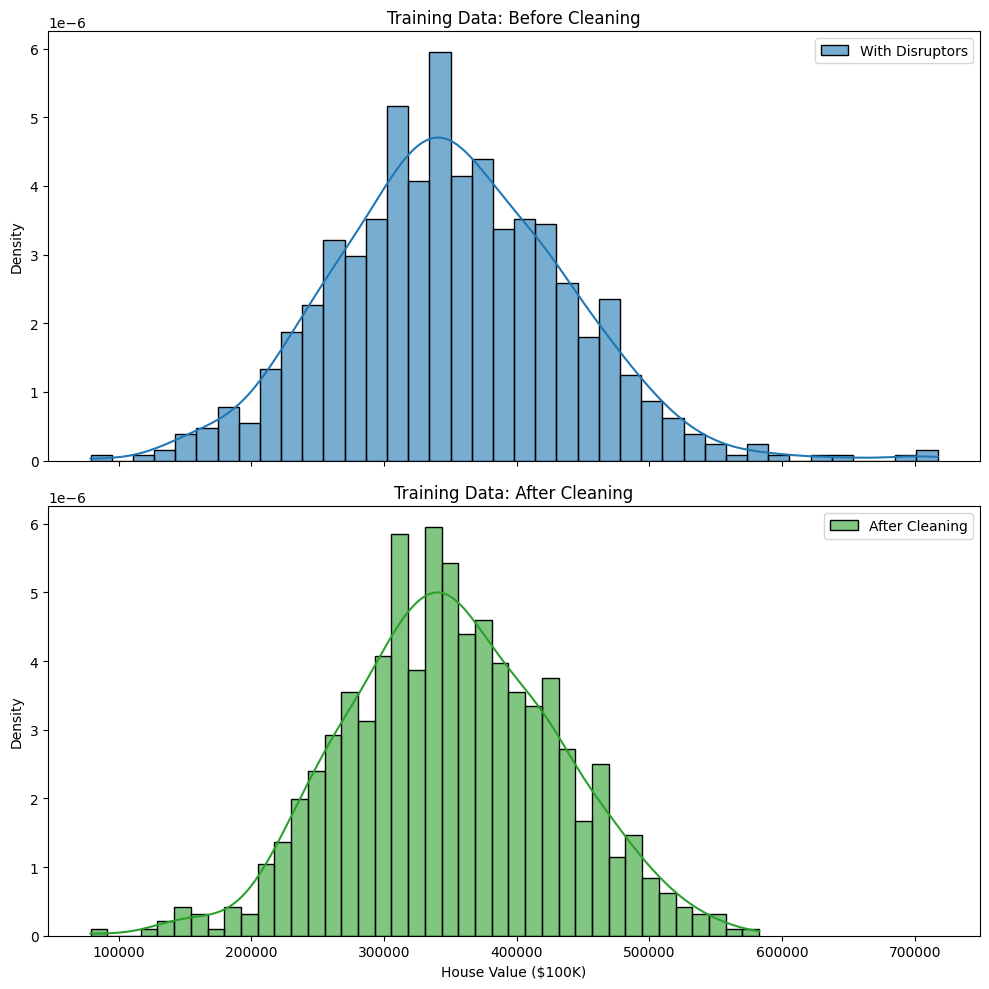

Target distribution comparison:
Before cleaning - Mean: $351438.6K, Std: $76937.7K
After cleaning  - Mean: $349909.3K, Std: $78758.8K


In [11]:
# Compare data distributions before and after cleaning using seaborn, vertically stacked for range comparison
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Before cleaning
sns.histplot(y_with_disruptors, bins=40, kde=True, ax=ax1, color=MPL_BLUE, alpha=0.6, stat='density', label='With Disruptors')
ax1.set_title('Training Data: Before Cleaning')
ax1.set_ylabel('Density')
ax1.legend()

# After cleaning
sns.histplot(y_clean, bins=40, kde=True, ax=ax2, color=MPL_GREEN, alpha=0.6, stat='density', label='After Cleaning')
ax2.set_title('Training Data: After Cleaning')
ax2.set_xlabel('House Value ($100K)')
ax2.set_ylabel('Density')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Target distribution comparison:")
print(f"Before cleaning - Mean: ${y_train.mean():.1f}K, Std: ${y_train.std():.1f}K")
print(f"After cleaning  - Mean: ${y_clean.mean():.1f}K, Std: ${y_clean.std():.1f}K")

## 5. Model Performance Comparison

Let's train a new model on the cleaned data and compare its performance to the baseline.

Training model on cleaned data...

=== Regression Metrics & Diagnostics ===

1. Error Metrics
----------------------------------------
• RMSE:         20832.225      (Root Mean Squared Error)
• MAE:          16211.987      (Mean Absolute Error)
• Median AE:    12969.741      (Median Absolute Error)
• NRMSE Mean:   6.0%      (RMSE/mean)
• NRMSE Std:    26.6%      (RMSE/std)
• NRMSE IQR:    19.7%      (RMSE/IQR)
• MAPE:         4.9%      (Mean Abs % Error, excl. zeros)
• SMAPE:        4.9%      (Symmetric Mean Abs % Error)

2. Goodness of Fit
----------------------------------------
• R²:           0.929      (Coefficient of Determination)
• Adj. R²:      0.929      (Adjusted for # of features)

3. Improvement over Baseline
----------------------------------------
• vs Mean:      73.4%      (RMSE improvement)
• vs Median:    73.4%      (RMSE improvement)


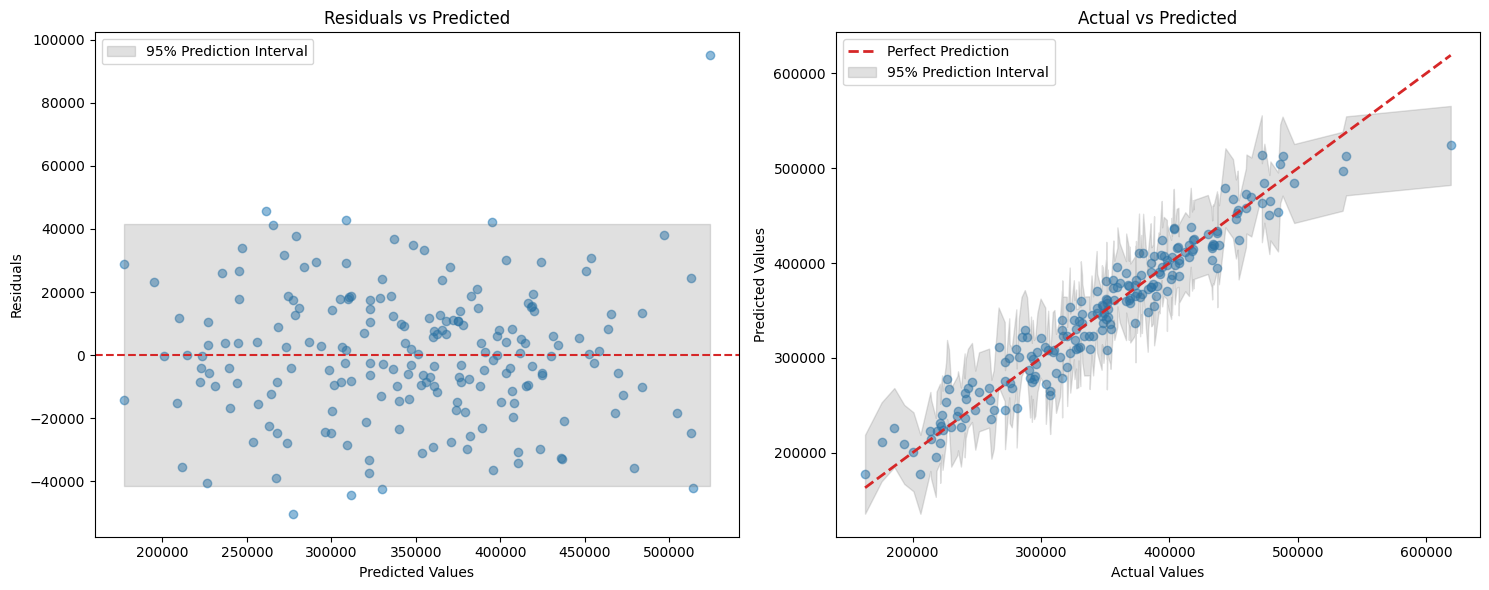

In [12]:
# Train model on cleaned data
cleaned_pipeline = MLPipeline(
    model=lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    preprocessor=PreProcessor()
)

print("Training model on cleaned data...")
cleaned_pipeline.fit(X_clean, y_clean)

# Evaluate on the same test set
cleaned_results = cleaned_pipeline.evaluate(
    X_test, y_test,
    verbose=True,
    visualize=True
)

In [13]:
# Compare key metrics
print("=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

metrics_to_compare = ['rmse', 'mae', 'r2', 'nrmse_mean']

print(f"{'Metric':<20} {'Baseline':<12} {'Cleaned':<12} {'Improvement':<12}")
print("-" * 60)

for metric in metrics_to_compare:
    baseline_val = baseline_results.get(metric, 0)
    cleaned_val = cleaned_results.get(metric, 0)
    
    if metric in ['rmse', 'mae', 'nrmse_mean']:  # Lower is better
        improvement = (baseline_val - cleaned_val) / baseline_val * 100
        improvement_str = f"{improvement:+.1f}%"
    else:  # Higher is better (r2_score)
        improvement = (cleaned_val - baseline_val) / abs(baseline_val) * 100
        improvement_str = f"{improvement:+.1f}%"
    
    if metric == 'nrmse_mean':
        baseline_str = f"{baseline_val:.1f}%"
        cleaned_str = f"{cleaned_val:.1f}%"
    else:
        baseline_str = f"{baseline_val:.3f}"
        cleaned_str = f"{cleaned_val:.3f}"
    
    print(f"{metric.upper():<20} {baseline_str:<12} {cleaned_str:<12} {improvement_str:<12}")

print("\nKey Insights:")
print("• Lower RMSE and MAE = Better predictive accuracy")
print("• Higher R² = Better explained variance") 
print("• Lower NRMSE = Better relative accuracy")

PERFORMANCE COMPARISON
Metric               Baseline     Cleaned      Improvement 
------------------------------------------------------------
RMSE                 27352.049    20832.225    +23.8%      
MAE                  21334.239    16211.987    +24.0%      
R2                   0.878        0.929        +5.8%       
NRMSE_MEAN           7.9%         6.0%         +23.8%      

Key Insights:
• Lower RMSE and MAE = Better predictive accuracy
• Higher R² = Better explained variance
• Lower NRMSE = Better relative accuracy


## 6. Quick Comparison across Algorithms

Let's do a quick run to loop the workflow over the disrupted vs cleaned training set across different algorithms to see the impact on model performance. 

Testing Cook's-like influence across different algorithms...

Testing Linear Regression...
  RMSE: 15152.564 → 14884.418 (+1.8%)
  R²:   0.963 → 0.964 (+0.1%)

Testing Random Forest...
  RMSE: 25288.829 → 21191.109 (+16.2%)
  R²:   0.896 → 0.927 (+3.5%)

Testing LightGBM...
  RMSE: 23809.072 → 19606.485 (+17.7%)
  R²:   0.908 → 0.937 (+3.3%)


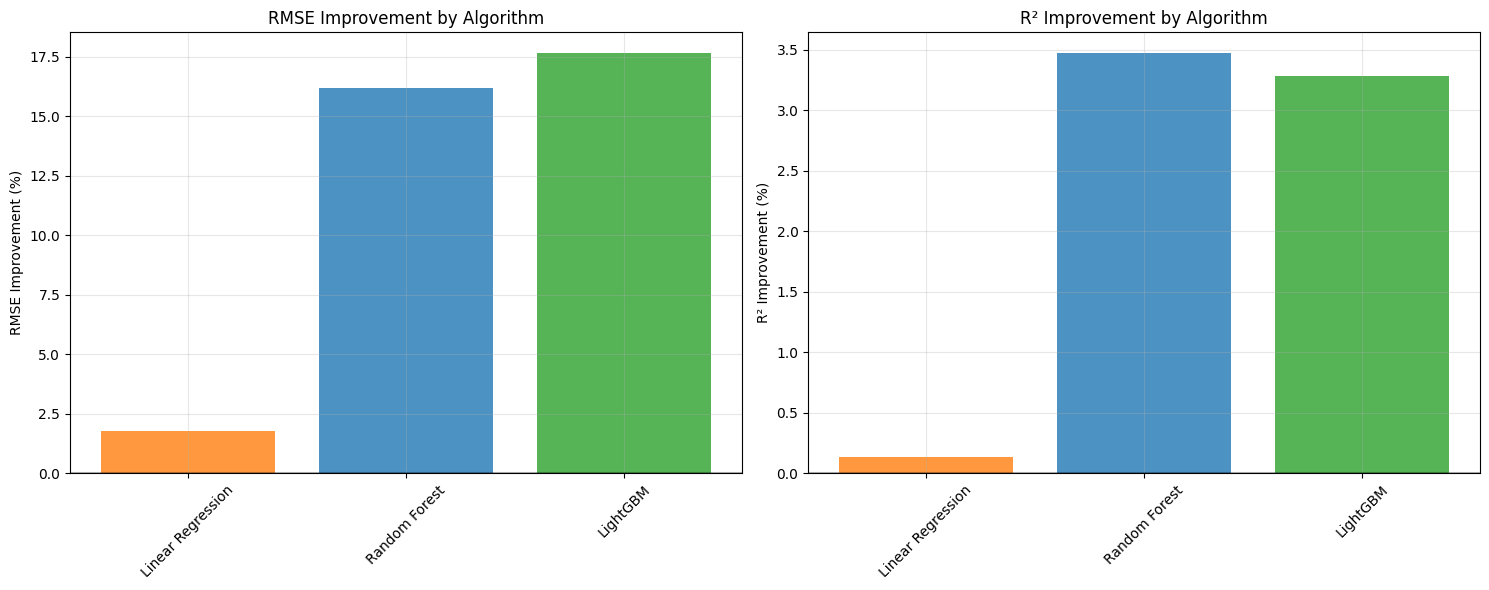

In [14]:
# Test with different algorithms
algorithms = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=50, random_state=42, verbose=-1)
}

algorithm_results = {}

print("Testing Cook's-like influence across different algorithms...")
print("=" * 70)

for name, model in algorithms.items():
    print(f"\nTesting {name}...")
    
    # Train on original data with disruptors
    pipeline_original = MLPipeline(model=model, preprocessor=PreProcessor())
    pipeline_original.fit(X_with_disruptors, y_with_disruptors)
    original_metrics = pipeline_original.evaluate(X_test, y_test, verbose=False, visualize=False)
    
    # Train on cleaned data  
    pipeline_cleaned = MLPipeline(model=model, preprocessor=PreProcessor())
    pipeline_cleaned.fit(X_clean, y_clean)
    cleaned_metrics = pipeline_cleaned.evaluate(X_test, y_test, verbose=False, visualize=False)
    
    # Calculate improvement
    rmse_improvement = (original_metrics['rmse'] - cleaned_metrics['rmse']) / original_metrics['rmse'] * 100
    r2_improvement = (cleaned_metrics['r2'] - original_metrics['r2']) / abs(original_metrics['r2']) * 100
    
    algorithm_results[name] = {
        'original_rmse': original_metrics['rmse'],
        'cleaned_rmse': cleaned_metrics['rmse'], 
        'rmse_improvement': rmse_improvement,
        'original_r2': original_metrics['r2'],
        'cleaned_r2': cleaned_metrics['r2'],
        'r2_improvement': r2_improvement
    }
    
    print(f"  RMSE: {original_metrics['rmse']:.3f} → {cleaned_metrics['rmse']:.3f} ({rmse_improvement:+.1f}%)")
    print(f"  R²:   {original_metrics['r2']:.3f} → {cleaned_metrics['r2']:.3f} ({r2_improvement:+.1f}%)")

# Summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

algorithms_list = list(algorithm_results.keys())
rmse_improvements = [algorithm_results[alg]['rmse_improvement'] for alg in algorithms_list]
r2_improvements = [algorithm_results[alg]['r2_improvement'] for alg in algorithms_list]

ax1.bar(algorithms_list, rmse_improvements, color=[MPL_YELLOW, MPL_BLUE, MPL_GREEN], alpha=0.8)
ax1.set_title('RMSE Improvement by Algorithm')
ax1.set_ylabel('RMSE Improvement (%)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)

ax2.bar(algorithms_list, r2_improvements, color=[MPL_YELLOW, MPL_BLUE, MPL_GREEN], alpha=0.8)
ax2.set_title('R² Improvement by Algorithm')
ax2.set_ylabel('R² Improvement (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# Expansion to Classification Models 

- The change is implemented from v0.5.0
- See CHANGELOG for details. 

Performing Cook's-D-like influence calculation for ALL points.
  Processed 21/200 selected samples.
  Processed 42/200 selected samples.
  Processed 63/200 selected samples.
  Processed 84/200 selected samples.
  Processed 105/200 selected samples.
  Processed 126/200 selected samples.
  Processed 147/200 selected samples.
  Processed 168/200 selected samples.
  Processed 189/200 selected samples.
  Processed 200/200 selected samples.
Identified 10 points above the 95th percentile threshold.


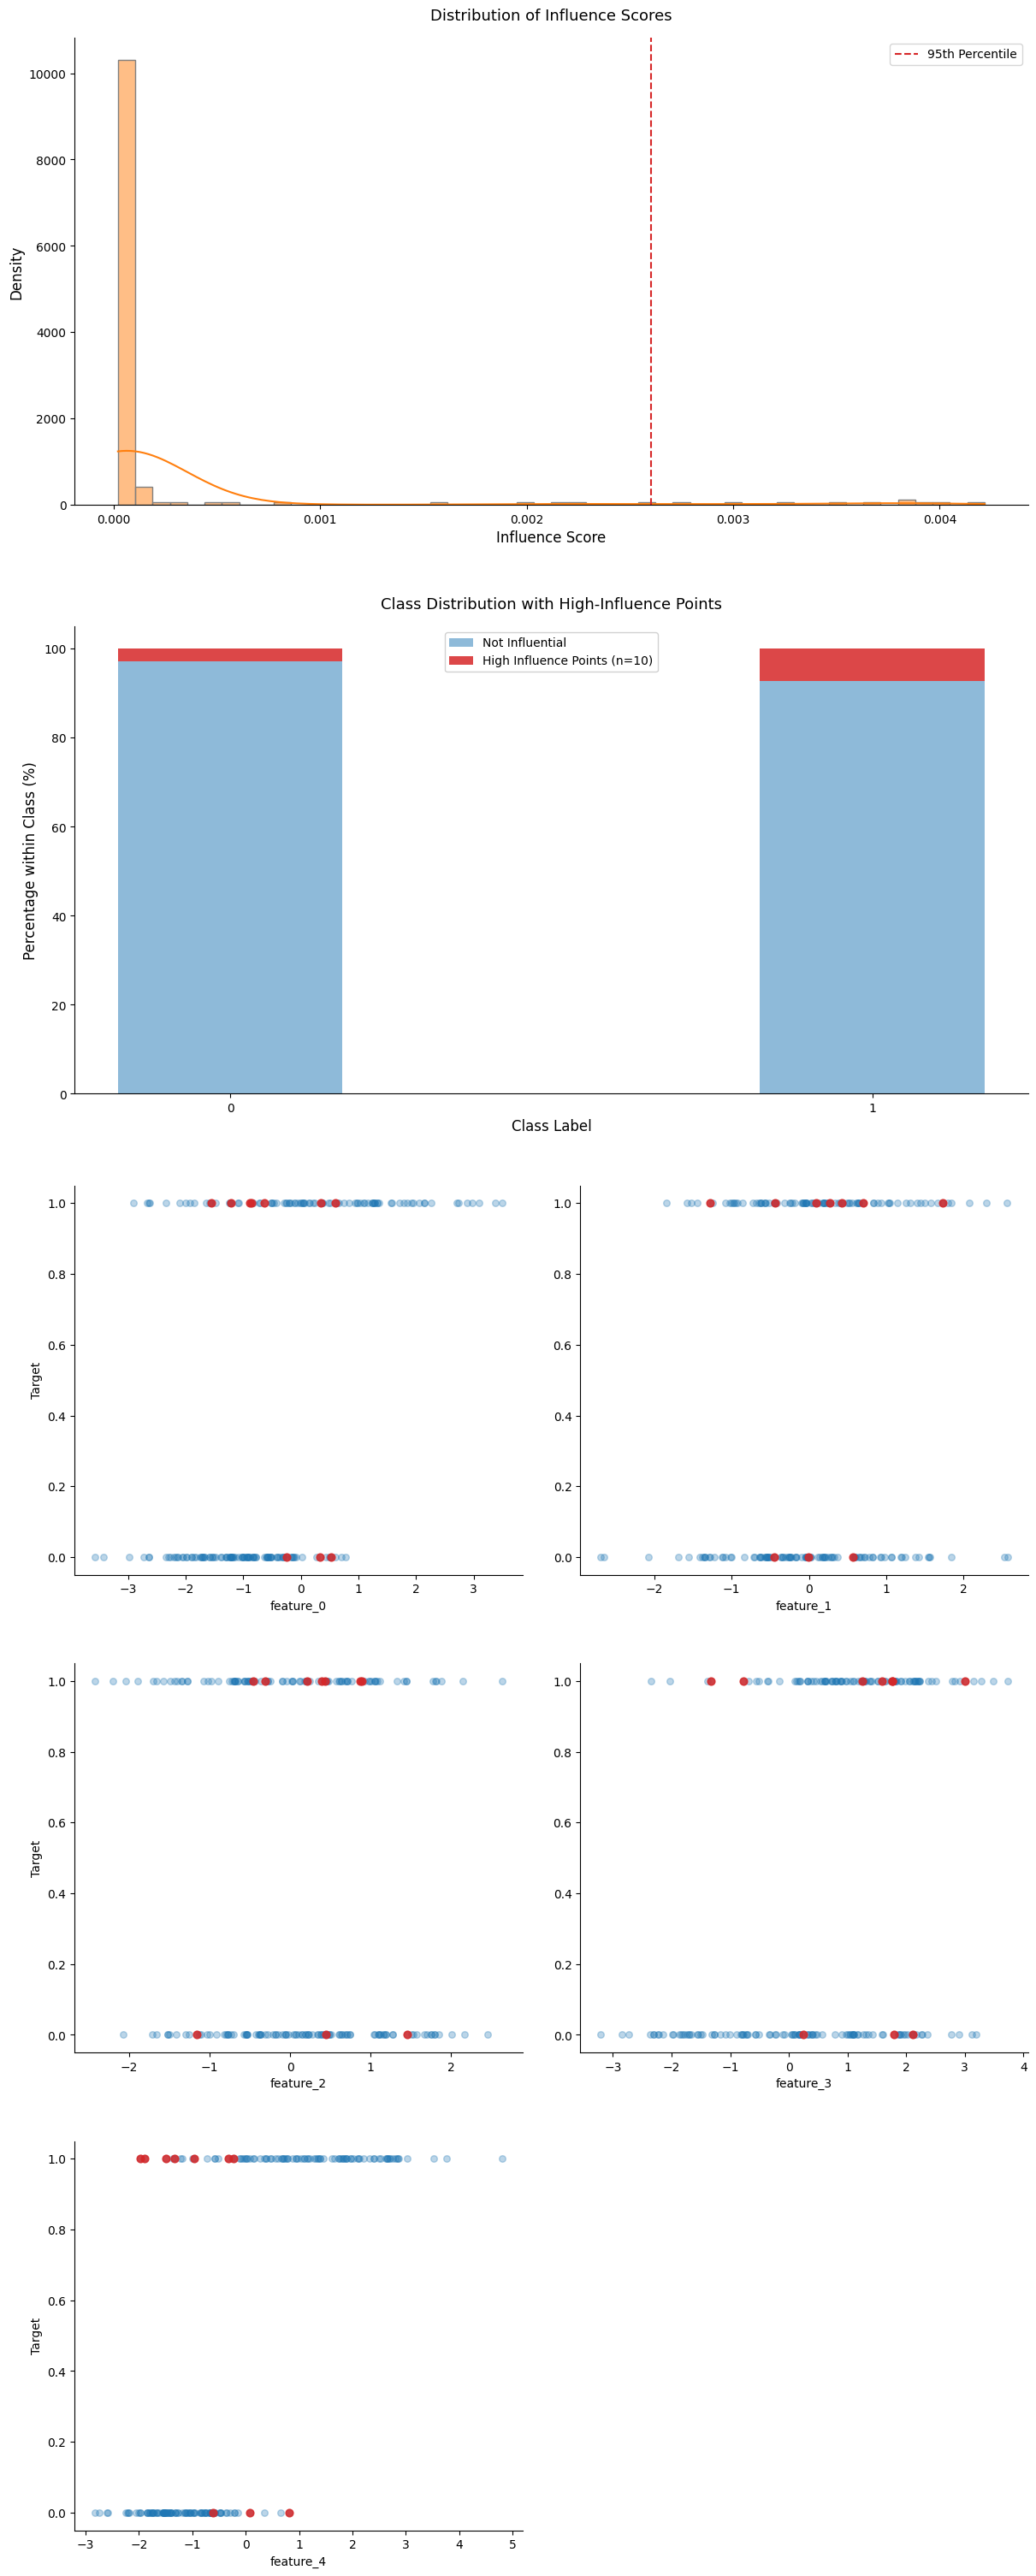

In [15]:
from sklearn.datasets import make_classification

# Reproducible synthetic binary dataset
X, y = make_classification(
    n_samples=200,
    n_features=5,
    n_informative=3,
    n_redundant=0,
    n_classes=2,
    class_sep=1.2,
    flip_y=0.03,
    random_state=42
)

# Convert to DataFrame for your function
X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])

model_params = {'verbose':-1}
influence_scores, influential_indices, normal_indices = calculate_cooks_d_like_influence(
    model_class = lgb.LGBMClassifier,
    X = X,
    y = y,
    visualize = True,
    influence_outlier_method = "percentile",
    influence_outlier_threshold = 95,  
    random_state = 42,
    **model_params
)